![LogoUC3M](https://login.uc3m.es/imgs/uc3m.png)

# Machine Learning · Bachelor in Management and Technology
# Tutorial 2: Hyperparameter optimization

Hyperparameter optimization is an essential step in machine learning that can significantly impact the performance of your model. In this notebook, we will explore various techniques for optimizing hyperparameters and learn how to use them in practice. We will cover both manual and automated methods for hyperparameter tuning, including grid search, random search, and Optuna optimization (via an external integrated package to Scikit-Learn). We will also discuss the advantages and limitations of each method and provide practical examples to help you get started with hyperparameter optimization. By the end of this notebook, you will have a solid understanding of hyperparameter optimization and the tools necessary to fine-tune your machine learning models for optimal performance.

One important aspect of hyperparameter optimization is the evaluation of different hyperparameter configurations. To do this, we typically use a validation set to estimate the performance of each configuration. However, selecting the best hyperparameters based on a single validation set can lead to **overfitting**. To avoid this problem, we can use different methods like leave one out or nested cross-validation. These techniques allows us to estimate the performance of each hyperparameter configuration on unseen data and avoid overfitting.


# DECISION TREE HYPER-PARAMETERS. TUNING DECISION TREES



- **max_depth : int or None, optional (default=None)**
 The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Ignored if max_leaf_nodes is not None.

- **min_samples_split : int, optional (default=2)**
 The minimum number of samples required to split an internal node.

- There are more hyper-parameters:
 - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
 - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html



First, data is loaded, inputs go to X, outputs to y.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing

from scipy.stats import sem

california = fetch_california_housing(as_frame=True)
X = california.data.to_numpy()
y = california.target.to_numpy()
california.frame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [2]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

# COMBINING HYPER-PARAMETER TUNING AND MODEL EVALUATION

The combination of model evaluation and hyper-parameter tuning can be understood as two loops:
- An **external loop (outer)** that trains a model and tests the model
- An **internal loop (inner)**, where the training process consists on looking for the best hyper-parameters, and then obtaining the model with those best hyper-parameters.

First, we are going to use **Holdout** (train/test) for model evaluation (external loop or **outer**), and **3-fold crossvalidation** for hyper-parameter tuning (internal loop or **inner**). Hyper-parameters will be adjusted with **Gridsearch**.


## GRIDSEARCH

First of all, let's define our our python function for RMSE

In [3]:
def rmse(y_test, y_test_pred):
 """ This is my computation of Root Mean Squared Error """
 return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [4]:
from sklearn.model_selection import train_test_split

# Holdout for model evaluation. 33% of available data for test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

First, let's remember RMSE with default hyper-parameteres

In [5]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor()
np.random.seed(42)
regr.fit(X=X_train, y=y_train)
print(f"RMSE of tree with default hyper-pars: {rmse(y_test, regr.predict(X=X_test))}")


RMSE of tree with default hyper-pars: 0.7389833060012664


In [6]:
# Search space
param_grid = {'max_depth': list(range(2,30, 1)),
 'min_samples_split': list(range(2,30,1))}

In [7]:
param_grid

{'max_depth': [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 'min_samples_split': [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29]}

In [8]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import KFold


# Search space
inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperpars
regr = GridSearchCV(DecisionTreeRegressor(),
 param_grid,
 scoring='neg_mean_squared_error',
 cv=inner,
 n_jobs=12, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

Fitting 3 folds for each of 784 candidates, totalling 2352 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=12,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (grid-search): {rmse(y_test, regr.predict(X=X_test))}")

Let's see the best hyper-parameters and their score (MSE). We can see that they are near the extremes of parameter space.

In [ ]:
regr.best_params_, -regr.best_score_

## RANDOMIZED SEARCH

Now, let's use **Randomized Search** instead of gridsearch. Only 20 hyper-parameter value combinations will be tried (budget=20)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics

# Search space
param_grid = {'max_depth': [2, 4, 6, 8, 10, 12, 14],
 'min_samples_split': [2, 4, 6, 8, 10, 12, 14]}

# Inner eva )
regr.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14],
                         'min_samples_split': [2, 4, 6, 8, 10, 12, 14]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
param_grid

{'max_depth': [2, 4, 6, 8, 10, 12, 14],
 'min_samples_split': [2, 4, 6, 8, 10, 12, 14]}

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (random search): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (random search): 0.6647688056188821


As in the previous case, we identify the best parameters and the MSE

In [ ]:
regr.best_params_, -regr.best_score_

({'max_depth': 8, 'min_samples_split': 14}, 0.44782374157784616)

For **Randomized Search**, we can define the search space with statistical distributions, rather than using particular values as we did before. Below you can see how to use a uniform distribution on integers between 2 and 16 by means of *randint*. For continuous hyper-parameters we could use continuous distributions such as *uniform* or *expon* (exponential).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics


from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint

# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
 'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(),
 param_grid,
 scoring='neg_mean_squared_error',
 cv=inner,
 n_jobs=4, verbose=1,
 n_iter=budget
 )

np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=4,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d1bf79a3520>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d1bf79a0ee0>},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
param_grid['max_depth']

We can compare the best parameters and the best MSE with the previous estimations.

In [ ]:
regr.best_params_, -regr.best_score_

({'max_depth': 8, 'min_samples_split': 12}, 0.4483635388476918)

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (random search II): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (random search II): 0.6640044054767447


## QUESTIONS

- Which method worked better? GridSearch or Randomized Search? Why?
- What's the effect on `n_jobs` parameter? Can you speed it up?

## Exercise 1

Using this code as a template, and `fetch_california_housing` use KNN method instead of DecisionTree.

- `n_neighbors`
- `metric`



```
from sklearn.model_selection import RandomizedSearchCV, KFold
rom sklearn import metrics


from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint

# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
 'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(),
 param_grid,
 scoring='neg_mean_squared_error',
 cv=inner,
 n_jobs=1, verbose=1,
 n_iter=budget
 )

np.random.seed(42)
egr.fit(X=X_train, y=y_train)
```


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor


from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint


# Search space with integer uniform distributions
param_grid = {'n_neighbors': sp_randint(2,16),
 'metric': ['minkowski', 'euclidean', "l1", 'cosine']}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(KNeighborsRegressor(),
 param_grid,
 scoring='neg_mean_squared_error',
 cv=inner,
 n_jobs=3, verbose=1,
 n_iter=budget
 )

np.random.seed(42)
regr.fit(X=X_train, y=y_train)
print(f"RMSE of tree with hyper-parameter tuning (random search II): {rmse(y_test, regr.predict(X=X_test))}")

NameError: name 'np' is not defined

# Nested cross-validation

What if we wanted to do **model evaluation with 5-fold crossvalidation** and **hyper-parameter tuning with 3-fold crossvalidation**? This is called nested crossvalidation (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html). There is an external loop (for evaluating models) and an internal loop (for hyper-parameter tuning).

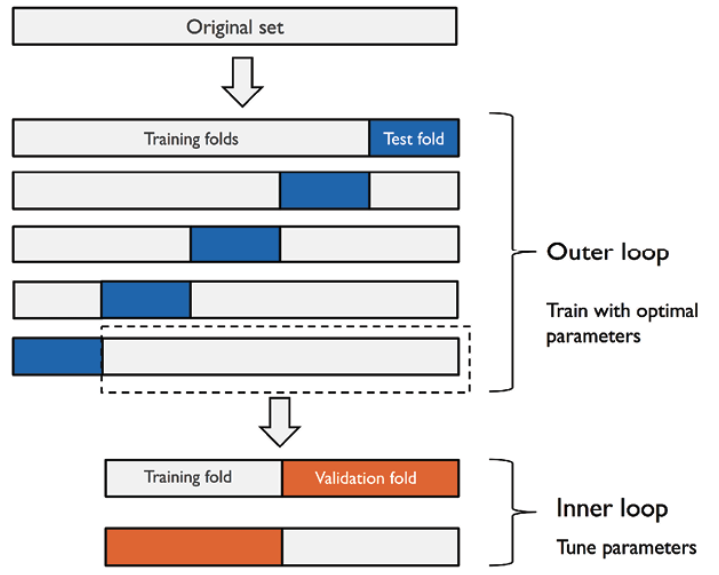

## Manual approach

In [ ]:
# manual nested cross-validation for Decision Tree Regressor
from numpy import mean
from numpy import std
#from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score

# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
# enumerate splits
outer_results = list()
param_grid = {'max_depth': list(range(2,16,2)),
 'min_samples_split': list(range(2,16,2))}
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=3, shuffle=True, random_state=42)
	# define the model
	model = DecisionTreeRegressor(random_state=1)
	# define search
	regr = RandomizedSearchCV(model,
 param_grid,
 scoring='neg_mean_squared_error',
 # 3-fold for hyper-parameter tuning
 cv=cv_inner, n_jobs=1, verbose=1,
 n_iter=20
 )
	# execute search
	result = regr.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	rmse_val = rmse(y_test, yhat)
	# store the result
	outer_results.append(rmse_val)
	# report progress
	print('>rmse=%.3f, est=%.3f, cfg=%s' % (rmse_val, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('RMSE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

NameError: name 'X' is not defined

In [ ]:
outer_results

[0.6487249185000089,
 0.6548658806942202,
 0.6324201599206799,
 0.6329305637224107,
 0.6435418288897442]

In [ ]:
np.mean(outer_results)

0.6424966703454128

# Using scikit-learn

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn import metrics

# random_state=0 for reproducibility
# Evaluation of model (outer loop)
outer = KFold(n_splits=5, shuffle=True, random_state=42)

from scipy.stats import uniform, expon

# Search space
param_grid = {'max_depth': list(range(2,16,2)),
 'min_samples_split': list(range(2,16,2))}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
# This is the internal 3-fold crossvalidation for hyper-parameter tuning
regr = RandomizedSearchCV(DecisionTreeRegressor(random_state=1),
 param_grid,
 scoring='neg_mean_squared_error',
 # 3-fold for hyper-parameter tuning
 cv=inner,
 n_jobs=1, verbose=1,
 n_iter=budget
 )

# This is the external 5-fold crossvalidation for model evaluation
# Notice that regr is the model resulting of hyper-parameter tuning
np.random.seed(42)

# For sklearn, higher scores are better. Given that MSE is an error (smaller is better), the corresponding score is -MSE
scores = -cross_val_score(regr,
 X, y,
 scoring='neg_mean_squared_error',
 cv = outer)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
print(scores)
# The score was MSE, we want RMSE
scores = np.sqrt(scores)
# The mean of the 5-fold crossvalidation is the final score of the model
print(f"{scores.mean()} +- {scores.std()}")

[0.420164   0.406341   0.41298659 0.39837609 0.41414609]
0.6406003948817545 +- 0.005821222905398511


#### OBTAINING THE FINAL MODEL (FOR DEPLOYMENT, OR FOR SENDING TO A COMPETITION, ...)

If at the end, we need a final model, we can get it by fitting regr to all the available data. Let us remember that regr does hyper.parameter tuning.

In [ ]:
np.random.seed(42)

# Fitting again the randomized search HPO
regrFinal = regr.fit(X,y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
regr.best_params_, np.sqrt(-regr.best_score_)

({'min_samples_split': 14, 'max_depth': 10}, 0.6319237773312396)

## Exercise 2

Using this code as a template, and `fetch_california_housing` use KNN method instead of DecisionTree.

- `n_neighbors`
- `metric`



```
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn import metrics

# random_state=0 for reproducibility
# Evaluation of model (outer loop)
outer = KFold(n_splits=5, shuffle=True, random_state=42)


from scipy.stats import uniform, expon

# Search space
param_grid = {'max_depth': list(range(2,16,2)),
 'min_samples_split': list(range(2,16,2))}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
# This is the internal 3-fold crossvalidation for hyper-parameter tuning
regr = RandomizedSearchCV(DecisionTreeRegressor(),
 param_grid,
 scoring='neg_mean_squared_error',
 # 3-fold for hyper-parameter tuning
 cv=inner,
 n_jobs=1, verbose=1,
 n_iter=budget
 )

# This is the external 5-fold crossvalidation for model evaluation
# Notice that regr is the model resulting of hyper-parameter tuning
np.random.seed(42)

# For sklearn, higher scores are better. Given that MSE is an error (smaller is better), the corresponding score is -MSE
scores = -cross_val_score(regr,
 X, y,
 scoring='neg_mean_squared_error',
 cv = outer)
```


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn import metrics

# random_state=0 for reproducibility
# Evaluation of model (outer loop)
outer = KFold(n_splits=5, shuffle=True, random_state=42)


from scipy.stats import uniform, expon

# Search space
param_grid = {'n_neighbors': list(range(2,16,2)),
 'metric': ['minkowski', 'euclidean', "l1", 'cosine']
}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
# This is the internal 3-fold crossvalidation for hyper-parameter tuning
regr = RandomizedSearchCV(KNeighborsRegressor(),
 param_grid,
 scoring='neg_mean_squared_error',
 # 3-fold for hyper-parameter tuning
 cv=inner,
 n_jobs=3, verbose=1,
 n_iter=budget
 )

# This is the external 5-fold crossvalidation for model evaluation
# Notice that regr is the model resulting of hyper-parameter tuning
np.random.seed(42)

# For sklearn, higher scores are better. Given that MSE is an error (smaller is better), the corresponding score is -MSE
scores = -cross_val_score(regr,
 X, y,
 scoring='neg_mean_squared_error',
 cv = outer)

print(scores)
# The score was MSE, we want RMSE
scores = np.sqrt(scores)
# The mean of the 5-fold crossvalidation is the final score of the model
print(f"{scores.mean()} +- {scores.std()}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0.72686793 0.76369013 0.758312   0.75317423 0.78661271]
0.870407657411943 +- 0.011041357388392866


# HYPERPARAMETER OPTIMIZATION FRAMEWORK (OPTUNA)

OPTUNA is an external package to Scikit-Learn providing an optimization framework for hyperparameter selection: https://optuna.org/. The framework provides a specific package called optuna-integration (https://optuna-integration.readthedocs.io/en/latest/), which enables taking advantage of Optuna's automated search with efficient algorithms while preserving the coding structure we are using based on Scikit-Learn.
In this tutorial, we shall explore **Holdout** for model evaluation and **3-fold crossvalidation** for hyper-parameter tuning (with **Optuna Hyperparameter Optimization**). Other option (less upgraded currently) is Bayesian Optimization, which is implemented with the package scikit-optimize of Scikit-Learn.

In [ ]:
#For accessing to different distributions and other methods
!pip install optuna
#For accesing to optuna.integration.OptunaSearchCV and enabling integration with Scikit-Learn
!pip install optuna-integration

In [ ]:
import optuna.integration
from optuna.distributions import IntDistribution as IntDist
from sklearn import metrics

# Search space with integer uniform distributions
param_grid_optuna = {'max_depth': IntDist(2,16),
 'min_samples_split': IntDist(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 50
regr_optuna = optuna.integration.OptunaSearchCV(DecisionTreeRegressor(),
 param_grid_optuna,
 scoring='neg_mean_squared_error',
 n_trials=budget,
 cv=inner,
 n_jobs=1, verbose=1,
 timeout=600,
 random_state=42,
 #refit=True
 )

np.random.seed(42)
regr_optuna.fit(X_train, y_train)

# At this point, regr_optuna contains the model with the best hyper-parameters found by OptunaSearchCV
# and trained on the complete X_train

<ipython-input-12-ec4e18221095>:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  regr_optuna = optuna.integration.OptunaSearchCV(DecisionTreeRegressor(),
[I 2024-12-01 08:58:27,873] A new study created in memory with name: no-name-3425bb6d-e514-40de-a5f3-6dd4a36db239
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 13828 samples...
[I 2024-12-01 08:58:28,065] Trial 0 finished with value: -0.4479620282807382 and parameters: {'max_depth': 8, 'min_samples_split': 14}. Best is trial 0 with value: -0.4479620282807382.
[I 2024-12-01 08:58:28,154] Trial 1 finished with value: -0.6332308682286406 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: -0.4479620282807382.
[I 2024-12-01 08:58:28,361] Trial 2 finished with value: -0.456344330933802 and parameters: {'max_depth': 9, 'min_samples_split': 6}. Best is trial 0 with value: -0.4479620282807382.
[I 2024

OptunaSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
               estimator=DecisionTreeRegressor(), n_jobs=1, n_trials=50,
               param_distributions={'max_depth': IntDistribution(high=16, log=False, low=2, step=1),
                                    'min_samples_split': IntDistribution(high=16, log=False, low=2, step=1)},
               random_state=42, scoring='neg_mean_squared_error', timeout=600,
               verbose=1)

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (Optuna optimization): {rmse(y_test, regr_optuna.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (Optuna optimization): 0.6648123621928317


As in previous cases, we can also identify the best parameters and the best score for MSE.

In [ ]:
regr_optuna.best_params_, -regr_optuna.best_score_

({'max_depth': 8, 'min_samples_split': 15}, 0.44473358686399606)

We can check if the optimization has converged by using plots.

<ipython-input-15-15e69a2637f7>:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(trial)


<Figure size 2500x2000 with 0 Axes>

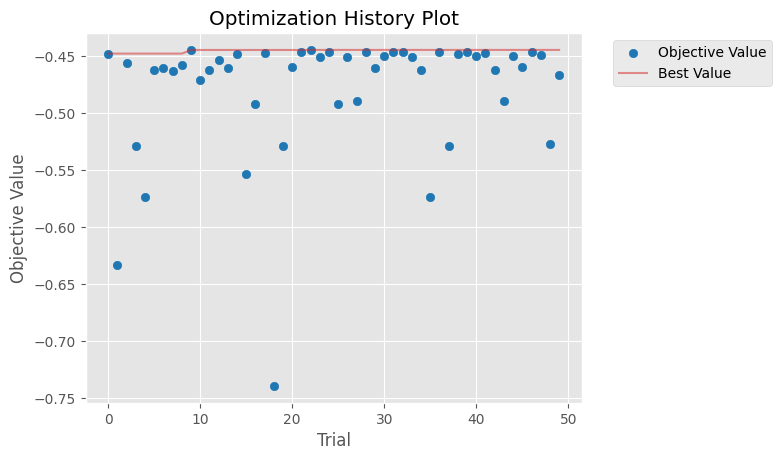

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history
fig = plt.figure(figsize=(25,20))
trial = regr_optuna.study_
plot_optimization_history(trial)
plt.show()

We can also visualize the importance of the different parameters y the final model.

<ipython-input-16-6973e17f3a44>:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(trial)


<Figure size 2500x2000 with 0 Axes>

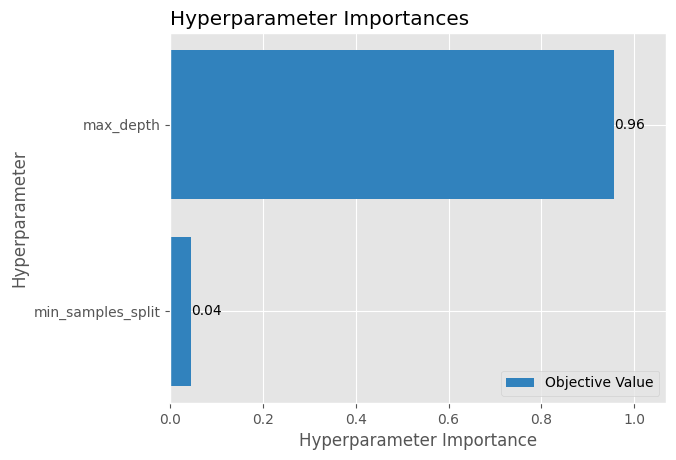

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances
fig = plt.figure(figsize=(25,20))
trial = regr_optuna.study_
plot_param_importances(trial)
plt.show()